# Описание проекта

Заказчик этого исследования — сеть отелей «Как в гостях».

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — **80%** от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.
В
отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.
Стоимость номеров отеля:

**категория A: за ночь — 1 000, разовое обслуживание — 400;**

**категория B: за ночь — 800, разовое обслуживание — 350;**

**категория C: за ночь — 600, разовое обслуживание — 350;**

**категория D: за ночь — 550, разовое обслуживание — 150;**

**категория E: за ночь — 500, разовое обслуживание — 150;**

**категория F: за ночь — 450, разовое обслуживание — 150;**

**категория G: за ночь — 350, разовое обслуживание — 150.**

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на **20%**, летом — на **40%**.

На разработку системы прогнозирования заложен бюджет — **400 000**. При этом необходимо учесть, что внедрение модели должно окупиться за год. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

In [1]:
# импортирую нужные библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split

import numpy as np

### Шаг 1. Откройте файлы с данными

In [3]:
# загружаю и просматриваю датасет
df_train = pd.read_csv('./data/hotel_train.csv', index_col = 0)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [13]:
df_train.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


In [7]:
# загружаю и просматриваю датасет
df_test = pd.read_csv('./data/hotel_test.csv', index_col=0)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [15]:
df_test.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


Согласно документации к данным:
* `id` — номер записи;
* `adults` — количество взрослых постояльцев;  
* `arrival_date_year` — год заезда;
* `arrival_date_month` — месяц заезда;
* `arrival_date_week_number ` — неделя заезда;
* `arrival_date_day_of_month` — день заезда;
* `babies` — количество младенцев;
* `booking_changes` — количество изменений параметров заказа;
* `children` — количество детей от 3 до 14 лет;
* `country` — гражданство постояльца;
* `customer_type` — тип заказчика:
`Contract` - договор с юридическим лицом, `Group` - групповой заезд, 
`Transient` - не связано с договором или групповым заездом,
`Transient-party` - не связано с договором или групповым заездом, но связано с бронированием типа Transient
* `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
* `distribution_channel` — канал дистрибуции заказа;
* `is_canceled` — отмена заказа;
* `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
* `lead_time` — количество дней между датой бронирования и датой прибытия;
* `meal` — опции заказа:
`SC` - нет дополнительных опций, `BB` - включён завтрак, 
`HB` - включён завтрак и обед, `FB` - включён завтрак, обед и ужин
* `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
* `previous_cancellations` — количество отменённых заказов у клиента;
* `required_car_parking_spaces` — необходимость места для автомобиля;
* `reserved_room_type` — тип забронированной комнаты;
* `stays_in_weekend_nights` — количество ночей в выходные дни;
* `stays_in_week_nights` — количество ночей в будние дни;
* `total_nights` — общее количество ночей;
* `total_of_special_requests` — количество специальных отметок.


### Шаг 2. Предобработка и исследовательский анализ данных

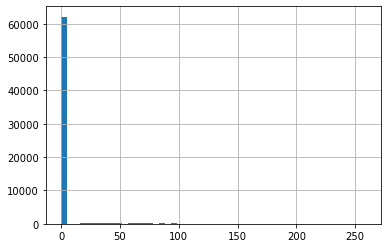

In [16]:
# строю гистограмму, чтобы найти выбросы
df_train['days_in_waiting_list'].hist(bins=50);

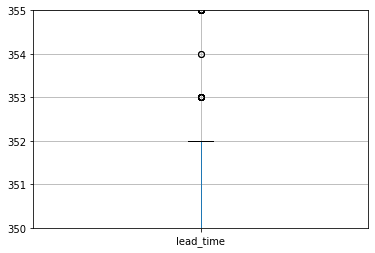

In [17]:
# строю диаграмму размаха для нахождения выбросов
plt.ylim(350, 355)
df_train.boxplot('lead_time', figsize=(10, 8));

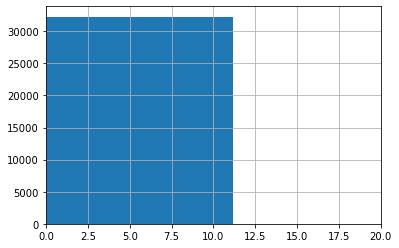

In [18]:
# строю гистограмму, чтобы найти выбросы
plt.xlim(0, 20)
df_test['days_in_waiting_list'].hist(bins=20);

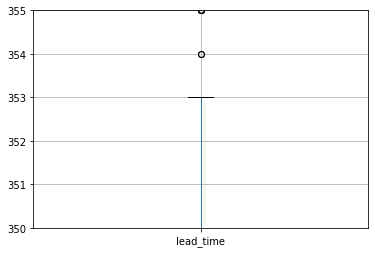

In [19]:
# строю диаграмму размаха для нахождения выбросов
plt.ylim(350, 355)
df_test.boxplot('lead_time', figsize=(10, 8));

In [20]:
# пишу функцию для предобработки данных

def start_processing(df, babies, adults, lead_time, days_in_waiting_list):
    index_del = (list(df[df['babies'] > babies].index) 
                 + list(df[df['adults'] == adults].index) 
                 + list(df[df['lead_time'] > lead_time].index) 
                 + list(df[df['days_in_waiting_list'] > days_in_waiting_list].index))
    df = df.drop(columns=['id'], axis=0)
    df = df.drop(index_del, axis=0)
    df['meal'] = df['meal'].replace('       ', '', regex=True)
    df['reserved_room_type'] = df['reserved_room_type'].replace('               ', '', regex=True)
    
    return df
    

In [21]:
# применяю функцию
df_train = start_processing(df_train, 2, 0, 353, 13)
df_test = start_processing(df_test, 2, 0, 353, 13)

In [22]:
month_figure = pd.DataFrame({'January': 0.180564, 
                             'February': 0.328474, 
                             'March': 0.271734, 
                             'April': 0.357988, 
                             'May': 0.313227, 
                             'June': 0.369267, 
                             'July': 0.383449, 'August': 0.387616, 
                             'September': 0.388876, 
                             'October': 0.377193, 
                             'November': 0.316977, 
                             'December': 0.341454}, index=[0])

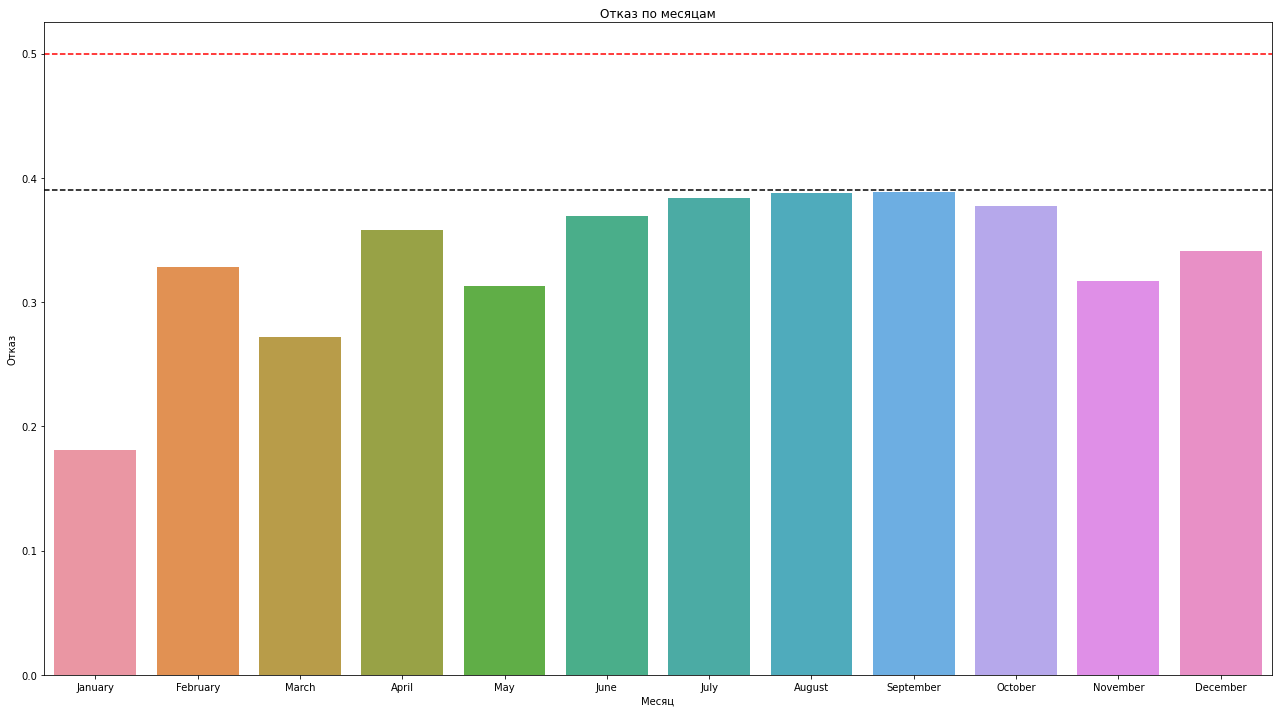

In [23]:
plt.figure(figsize=(22, 12))
ax = sns.barplot(data = month_figure);
ax.axhline(0.39, color="black", linestyle="--")
ax.axhline(0.5, color="red", linestyle="--")
plt.xlabel('Месяц');
plt.ylabel('Отказ');
plt.title('Отказ по месяцам');
plt.show()

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center">Мини-вывод<a class="tocSkip"> </h2>
 Из данного графика видем, что чаще всего отказываются от брони в Августе, Сентябре, Июле, Июне, Октябре, Апреле. Ниже представлен список тех стран, посетители из которых чаще откзываются от брони. Могу сказать, что некоторые страны могут быть представлены всего 1 раз(их я не удалял, а сделал группу)

In [24]:
country = df_train.groupby('country')['is_canceled'].mean().sort_values()
country[country >= 0.5].index

Index(['KEN', 'PHL', 'TZA', 'MCO', 'CPV', 'PRT', 'SAU', 'GEO', 'NGA', 'ISL',
       'BGD', 'MDV', 'QAT', 'PAK', 'IDN', 'ARE', 'HND', 'GLP', 'GGY', 'UZB',
       'HKG', 'VGB', 'ZMB', 'JEY', 'MAC', 'TJK', 'BEN', 'AND', 'NIC', 'IMN',
       'KHM'],
      dtype='object', name='country')

In [25]:
lead_time = df_train.groupby('lead_time')['is_canceled'].mean()
pd.Series(lead_time[lead_time >=0.5].index).mean()

255.8125

In [26]:
print('Количество людей, которые сделали бронь более, чем за 255 суток равно:', 
      df_train[df_train['lead_time'] > 255].shape[0])

Количество людей, которые сделали бронь более, чем за 255 суток равно: 5728


In [27]:
reliable_more = df_train[(df_train['lead_time'] > 255) & (df_train['is_canceled'] == 0)]
reliable_less = df_train[(df_train['lead_time'] < 255) & (df_train['is_canceled'] == 0)]
unreliable_more = df_train[(df_train['lead_time'] > 255) & (df_train['is_canceled'] == 1)]
unreliable_less = df_train[(df_train['lead_time'] < 255) & (df_train['is_canceled'] == 1)]

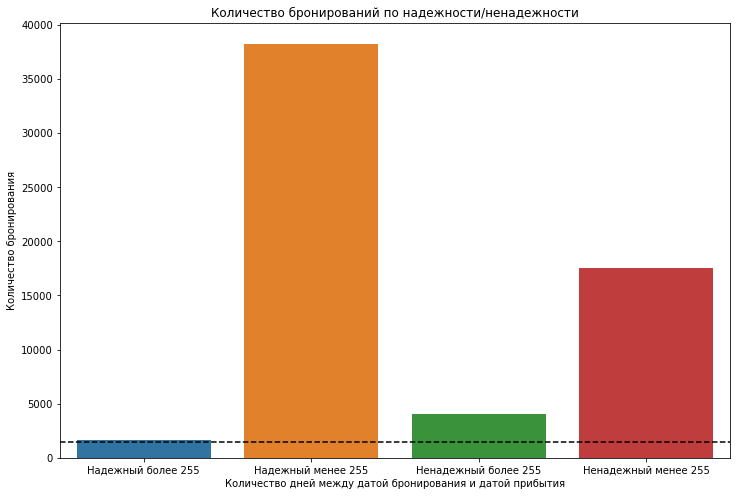

In [28]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=pd.DataFrame({'Надежный более 255': reliable_more['lead_time'].count(), 
                                    'Надежный менее 255': reliable_less['lead_time'].count(), 
                                    'Ненадежный более 255': unreliable_more['lead_time'].count(), 
                                    'Ненадежный менее 255': unreliable_less['lead_time'].count()}, index=[0]));
plt.xlabel('Количество дней между датой бронирования и датой прибытия');
plt.ylabel('Количество бронирования');
plt.title('Количество бронирований по надежности/ненадежности');
ax.axhline(1500, color="black", linestyle="--")
plt.show()

Доля надёжных и ненадёжных клиентов с числом дней от бронирования до прибытия более 255 отличается.

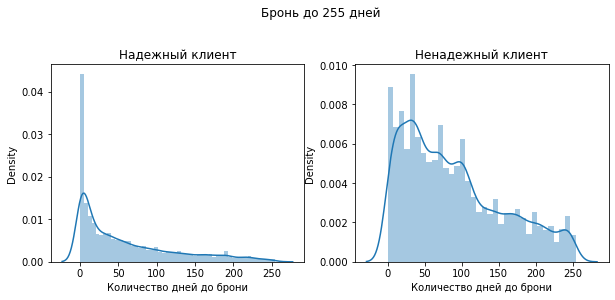

In [36]:
ax = plt.figure(figsize=(10, 8))
ax.suptitle('Бронь до 255 дней')
plt.subplot(2, 2, 1)
sns.distplot(reliable_less['lead_time'], kde=True)
plt.xlabel('Количество дней до брони')
plt.title('Надежный клиент')
plt.subplot(2, 2, 2)
sns.distplot(unreliable_less['lead_time'], kde=True)
plt.xlabel('Количество дней до брони')
plt.title('Ненадежный клиент')
plt.show()

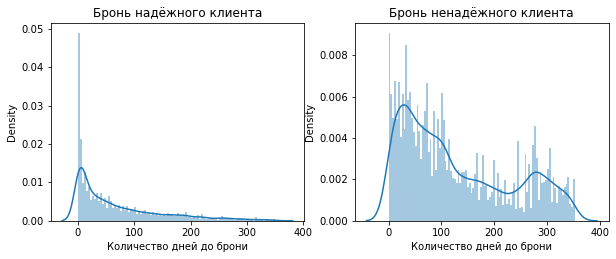

In [37]:
ax = plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
sns.distplot(df_train[df_train['is_canceled'] == 0]['lead_time'], bins=100, kde=True)
plt.xlabel('Количество дней до брони')
plt.title('Бронь надёжного клиента')
plt.subplot(2, 2, 2)
sns.distplot(df_train[df_train['is_canceled'] == 1]['lead_time'], bins=100, kde=True)
plt.xlabel('Количество дней до брони')
plt.title('Бронь ненадёжного клиента')
plt.show()

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center">Мини-вывод<a class="tocSkip"> </h2>
Ситуация интересная, у нас вообще недостаток данных, чтобы делать какие-либо выводы(в частности, за клиентов, который делают бронь более, чем за 255 вперед). Из графиков распределения видно, что отказы есть везде, а меньше отказов в первые 100 дней брони. Можно сказать, но не утверждать, что колиент, который бронирует день менее, чем 255 дней, то больше шанс, что отказа не будет, т.к. основное количество данных в этих подгруппах.

In [38]:
diwl = df_train.groupby('days_in_waiting_list')['is_canceled'].mean()
pd.Series(diwl[diwl >= 0.5].index).mean()

7.666666666666667

In [39]:
reliable_more_list = df_train[(df_train['days_in_waiting_list'] > 8) & (df_train['is_canceled'] == 0)]
reliable_less_list = df_train[(df_train['days_in_waiting_list'] < 8) & (df_train['is_canceled'] == 0)]
unreliable_more_list = df_train[(df_train['days_in_waiting_list'] > 8) & (df_train['is_canceled'] == 1)]
unreliable_less_list = df_train[(df_train['days_in_waiting_list'] < 8) & (df_train['is_canceled'] == 1)]

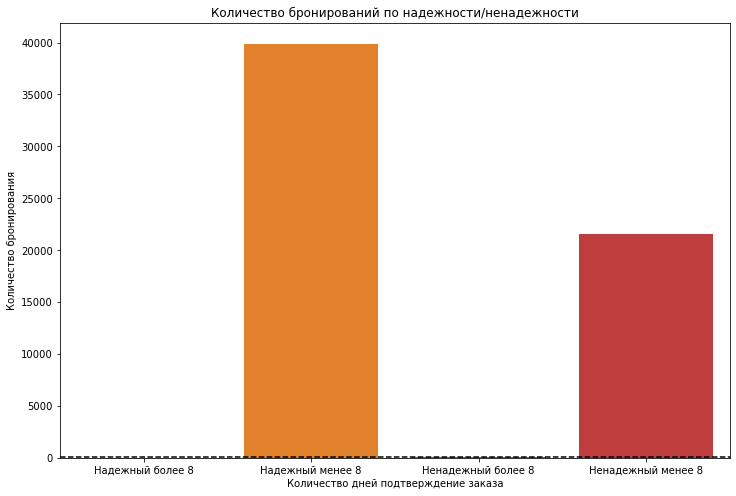

In [40]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=pd.DataFrame({'Надежный более 8': reliable_more_list['lead_time'].count(), 
                                    'Надежный менее 8': reliable_less_list['lead_time'].count(), 
                                    'Ненадежный более 8': unreliable_more_list['lead_time'].count(), 
                                    'Ненадежный менее 8': unreliable_less_list['lead_time'].count()}, index=[0]));
plt.xlabel('Количество дней подтверждение заказа');
plt.ylabel('Количество бронирования');
plt.title('Количество бронирований по надежности/ненадежности');
ax.axhline(100, color="black", linestyle="--")
plt.show()

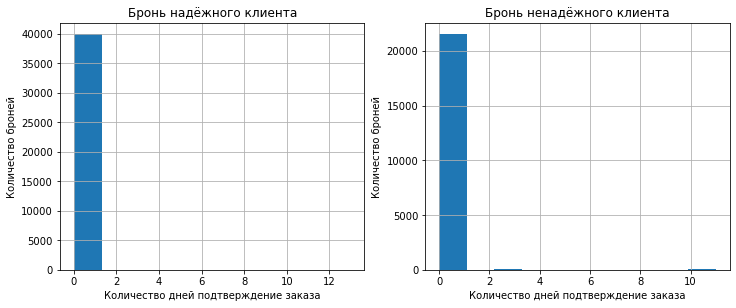

In [41]:
ax = plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
df_train[df_train['is_canceled'] == 0]['days_in_waiting_list'].hist()
plt.xlabel('Количество дней подтверждение заказа')
plt.ylabel('Количество броней')
plt.title('Бронь надёжного клиента')
plt.subplot(2, 2, 2)
df_train[df_train['is_canceled'] == 1]['days_in_waiting_list'].hist()
plt.xlabel('Количество дней подтверждение заказа')
plt.ylabel('Количество броней')
plt.title('Бронь ненадёжного клиента')
plt.show()

In [42]:
df_train[df_train['is_canceled'] == 1]['days_in_waiting_list'].shape[0]

21606

In [43]:
df_train[df_train['days_in_waiting_list'] == 0].shape[0]

61365

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center">Мини-вывод<a class="tocSkip"> </h2>
Слишком мало данных для того, чтобы сделать выводы. А также весь столбец почти равен значению 0, следовательно, заказ подтверждался очень быстро.

In [44]:
y = df_train.corr().drop(df_train.corr().index[0], axis=1).iloc[0].index
x = df_train.corr().drop(df_train.corr().index[0], axis=1).iloc[0]

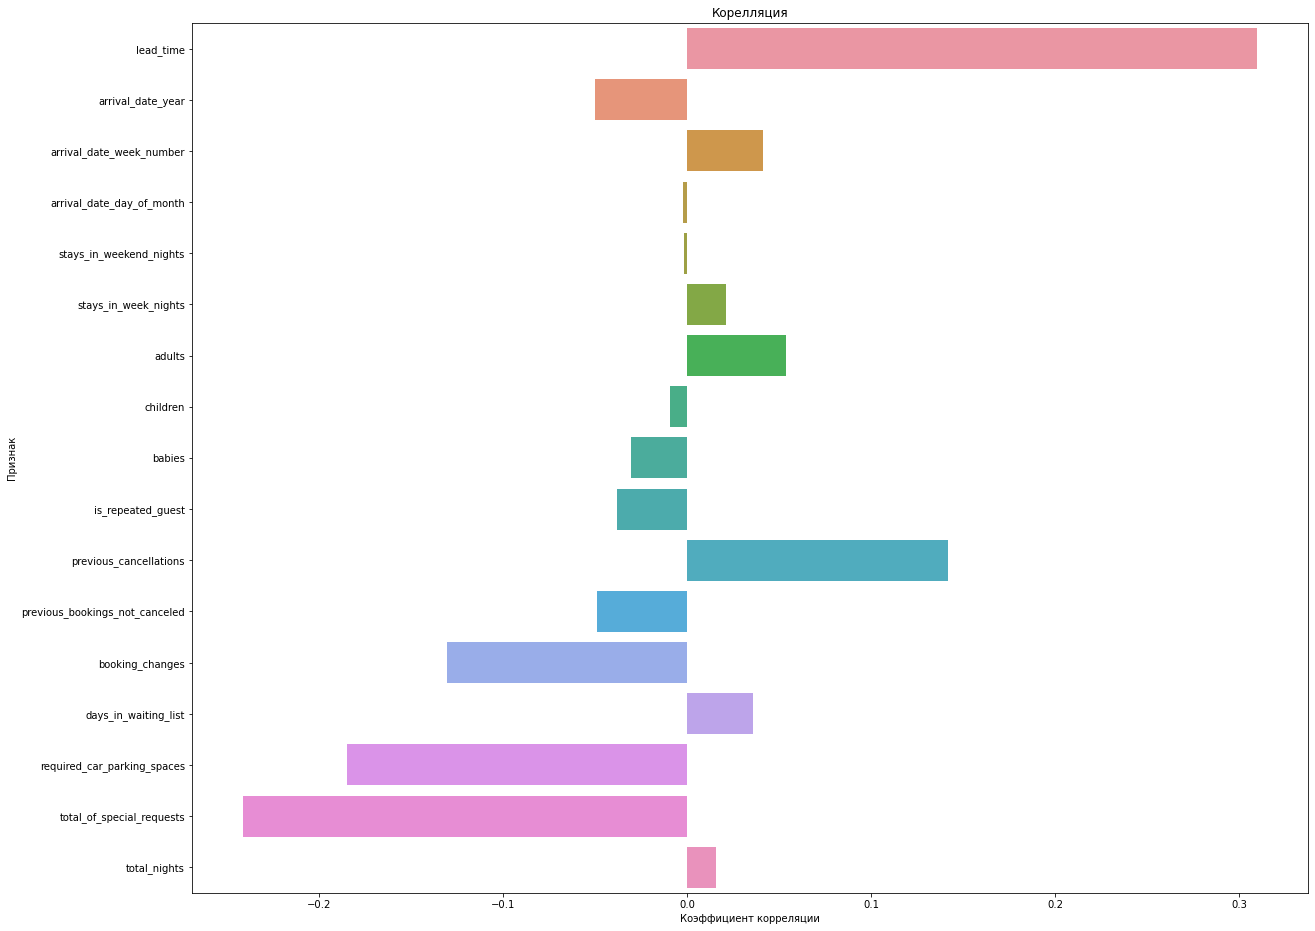

In [45]:
plt.figure(figsize=(20, 16))
sns.barplot(x=x, y=y);
plt.xlabel('Коэффициент корреляции');
plt.ylabel('Признак');
plt.title('Корелляция');

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center">Мини-вывод<a class="tocSkip"> </h2>
Из данной корреляции могу сказать, что чем больше количество дней между датой бронирования и датой прибытия, тем больше шанс, что клиент откажется. Чем больше количество изменений параметров заказа, количество специальных отметок и мест для автомобилей, тем меньше шанс того, что клиент откажется.

In [46]:
# просматриваю корреляции
df_train.corr()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
is_canceled,1.000000,0.309809,-0.049724,0.041329,-0.002271,-0.001672,0.021092,0.053757,-0.009464,-0.030484,-0.038014,0.141910,-0.049115,-0.130376,0.036010,-0.184862,-0.241407,0.015566
lead_time,0.309809,1.000000,-0.040614,0.102331,-0.005920,0.076712,0.183648,0.135372,-0.048350,-0.022842,-0.087603,0.139882,-0.065688,-0.002468,-0.001707,-0.111138,-0.120507,0.179838
arrival_date_year,-0.049724,-0.040614,1.000000,-0.370128,0.013686,-0.006077,0.013114,0.043046,0.050590,-0.006870,-0.006584,-0.144493,0.040594,0.044178,0.020067,0.015387,0.092224,0.007233
arrival_date_week_number,0.041329,0.102331,-0.370128,1.000000,0.055408,0.028459,0.028066,-0.007280,-0.009174,0.005793,-0.015698,0.019874,-0.010679,0.009262,-0.035041,-0.011739,0.071396,0.035607
arrival_date_day_of_month,-0.002271,-0.005920,0.013686,0.055408,1.000000,0.006088,0.002435,0.016997,0.019605,0.002152,-0.008253,-0.033258,0.001699,0.024375,0.011537,0.006211,0.009910,0.004845
stays_in_weekend_nights,-0.001672,0.076712,-0.006077,0.028459,0.006088,1.000000,0.214168,0.115270,0.021522,0.021156,-0.087951,-0.006689,-0.028856,0.022253,-0.016273,-0.021869,0.074318,0.651705
stays_in_week_nights,0.021092,0.183648,0.013114,0.028066,0.002435,0.214168,1.000000,0.129618,0.024094,0.023803,-0.095366,0.001461,-0.048723,0.056092,0.029560,-0.028547,0.092828,0.880448
adults,0.053757,0.135372,0.043046,-0.007280,0.016997,0.115270,0.129618,1.000000,0.050996,0.027802,-0.167214,0.002172,-0.125533,-0.045158,-0.002071,0.009746,0.180165,0.156600
children,-0.009464,-0.048350,0.050590,-0.009174,0.019605,0.021522,0.024094,0.050996,1.000000,0.020550,-0.027361,-0.024771,-0.016065,0.051086,-0.009668,0.050550,0.104221,0.029156
babies,-0.030484,-0.022842,-0.006870,0.005793,0.002152,0.021156,0.023803,0.027802,0.020550,1.000000,-0.013448,-0.008980,-0.007029,0.087050,-0.003650,0.035961,0.115837,0.028752


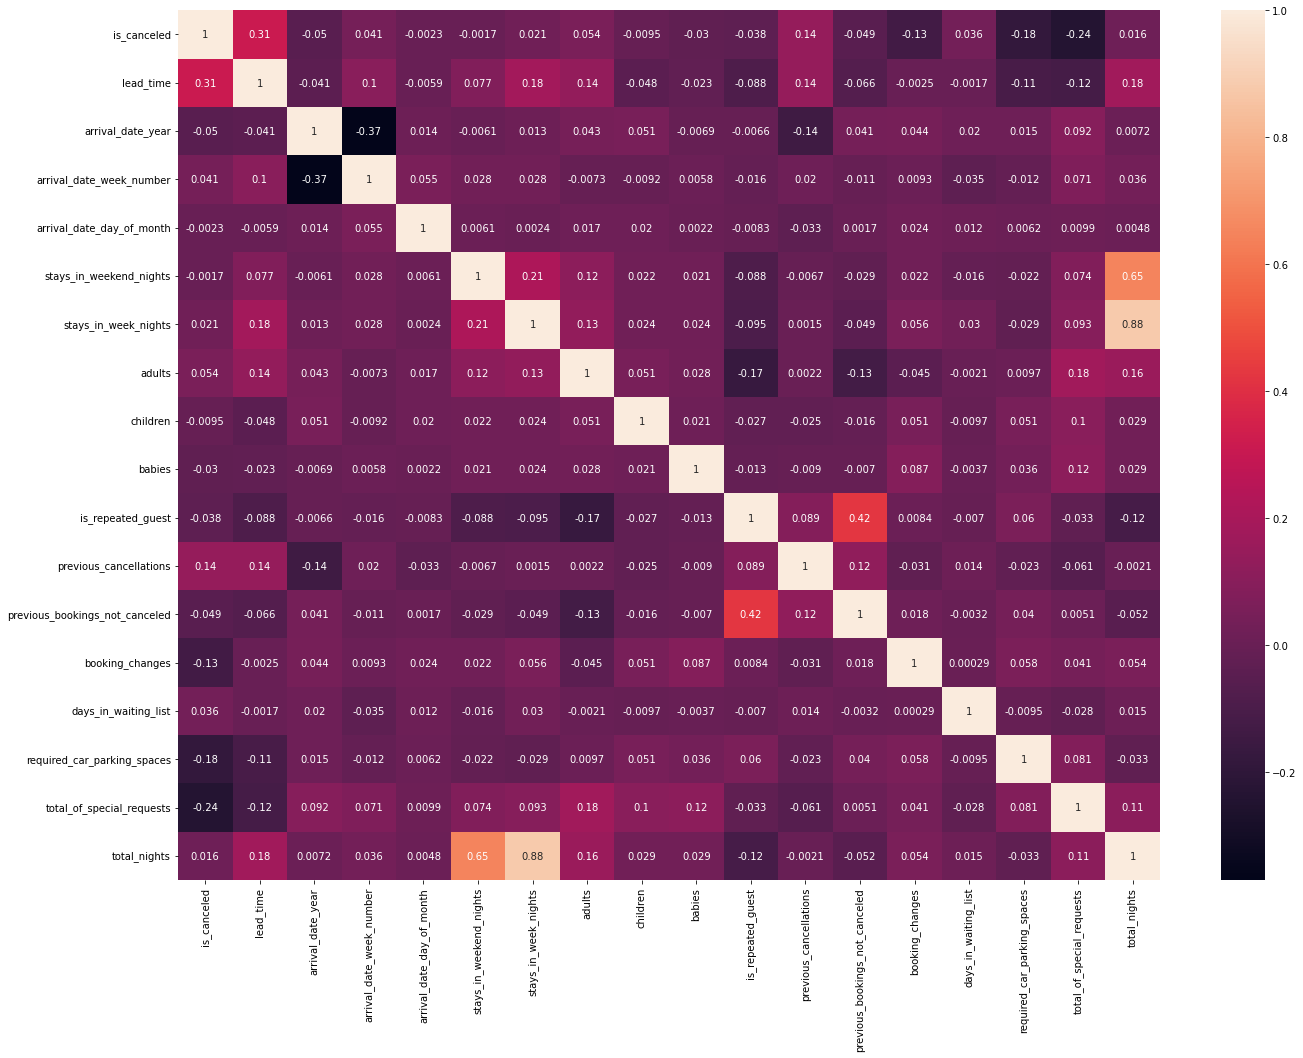

In [47]:
plt.figure(figsize=(22, 16))
sns.heatmap(df_train.corr(), annot=True);

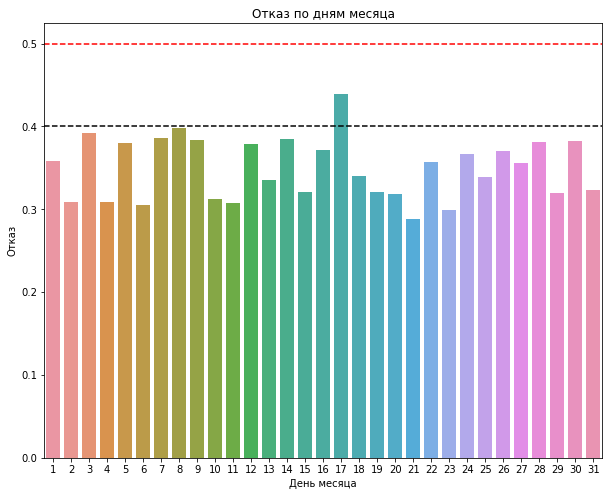

In [48]:
# строю столбчатую диаграмму с уровнем 0.4 и 0.5
month_day_figure = pd.DataFrame(dict(df_train.groupby('arrival_date_day_of_month')['is_canceled'].mean()), index = [0])
plt.figure(figsize=(10, 8))
ax = sns.barplot(data=month_day_figure);
ax.axhline(0.4, color="black", linestyle="--")
ax.axhline(0.5, color="red", linestyle="--")
plt.xlabel('День месяца');
plt.ylabel('Отказ');
plt.title('Отказ по дням месяца');
plt.show()

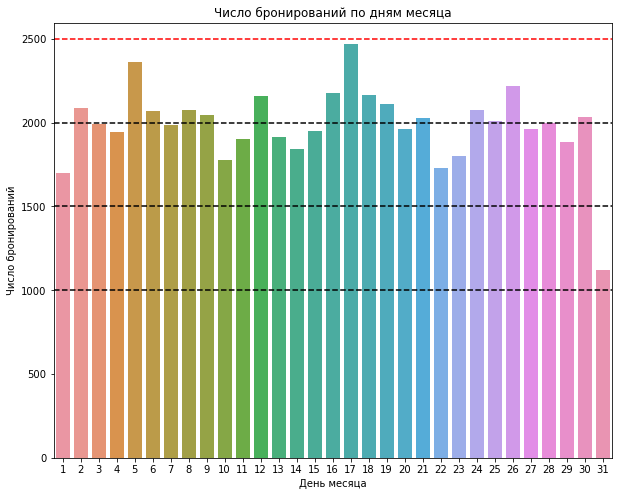

In [49]:
month_day_count = pd.DataFrame(dict(df_train.groupby('arrival_date_day_of_month')['is_canceled'].count()), index = [0])
plt.figure(figsize=(10, 8))
ax = sns.barplot(data=month_day_count);
ax.axhline(1500, color="black", linestyle="--")
ax.axhline(2500, color="red", linestyle="--")
ax.axhline(2000, color="black", linestyle="--")
ax.axhline(1000, color="black", linestyle="--")
plt.xlabel('День месяца');
plt.ylabel('Число бронирований');
plt.title('Число бронирований по дням месяца');
plt.show()

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center">Мини-вывод<a class="tocSkip"> </h2>
Из данных графиков могу сказать, что больше всего отказов происходит в середине месяца, а именно: в 17 день, а больше всего броней происходит на 6 день, 17 и 26.

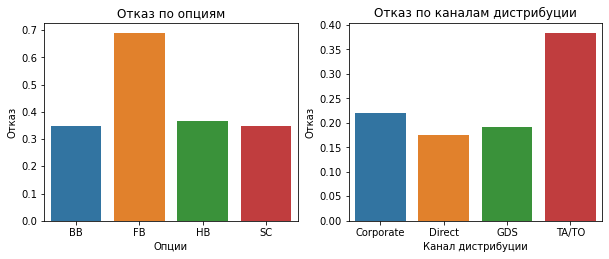

In [50]:
# строю диаграммы
dc_figure = pd.DataFrame(dict(df_train.groupby('distribution_channel')['is_canceled'].mean()), index = [0])
meal = pd.DataFrame(dict(df_train.groupby('meal')['is_canceled'].mean()), index = [0])
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
sns.barplot(data=meal);
plt.xlabel('Опции');
plt.ylabel('Отказ');
plt.title('Отказ по опциям');
plt.subplot(2, 2, 2)
sns.barplot(data=dc_figure);
plt.xlabel('Канал дистрибуции');
plt.ylabel('Отказ');
plt.title('Отказ по каналам дистрибуции');
plt.show()

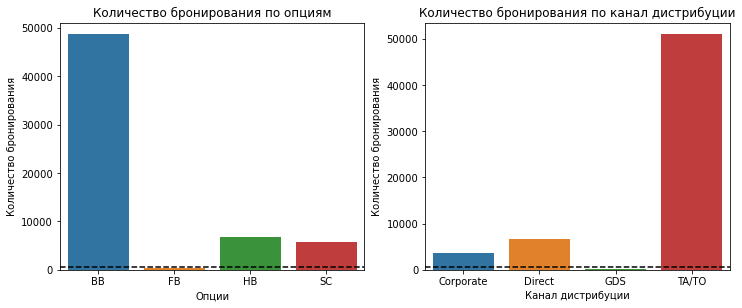

In [51]:
dc_count = pd.DataFrame(dict(df_train.groupby('distribution_channel')['is_canceled'].count()), index = [0])
meal_count = pd.DataFrame(dict(df_train.groupby('meal')['is_canceled'].count()), index = [0])
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
ax = sns.barplot(data=meal_count);
plt.xlabel('Опции');
plt.ylabel('Количество бронирования');
plt.title('Количество бронирования по опциям');
plt.subplot(2, 2, 2)
ax.axhline(500, color="black", linestyle="--")
ax = sns.barplot(data=dc_count);
plt.xlabel('Канал дистрибуции');
plt.ylabel('Количество бронирования');
plt.title('Количество бронирования по канал дистрибуции');
ax.axhline(500, color="black", linestyle="--")
plt.show()

In [52]:
display(dc_count)
meal_count

,Corporate,Direct,GDS,TA/TO
0,3721,6763,99,50930


,BB,FB,HB,SC
0,48615,450,6725,5723


<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center">Мини-вывод<a class="tocSkip"> </h2>
Данных мало, чтобы делать какие-то выводы. Можно сказать, что в канале дистрибуции TA/TO шанс, что человек отменит заказ - 38,4 процента, шанс того, что с опцией BB человек отменит заказ - 34,6 процента.

In [53]:
df_train.groupby('previous_cancellations')['is_canceled'].mean().sort_values(ascending=False)

previous_cancellations
6     1.000000
14    1.000000
19    1.000000
21    1.000000
24    1.000000
25    1.000000
26    1.000000
1     0.969588
2     0.415094
0     0.302066
3     0.270833
4     0.200000
5     0.153846
11    0.074074
13    0.000000
Name: is_canceled, dtype: float64

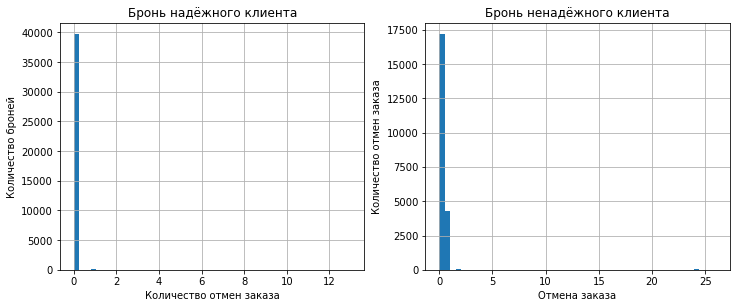

In [54]:
ax = plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
df_train[df_train['is_canceled'] == 0]['previous_cancellations'].hist(bins=50)
plt.xlabel('Количество отмен заказа')
plt.ylabel('Количество броней')
plt.title('Бронь надёжного клиента')
plt.subplot(2, 2, 2)
df_train[df_train['is_canceled'] == 1]['previous_cancellations'].hist(bins=50)
plt.xlabel('Отмена заказа')
plt.ylabel('Количество отмен заказа')
plt.title('Бронь ненадёжного клиента')
plt.show()

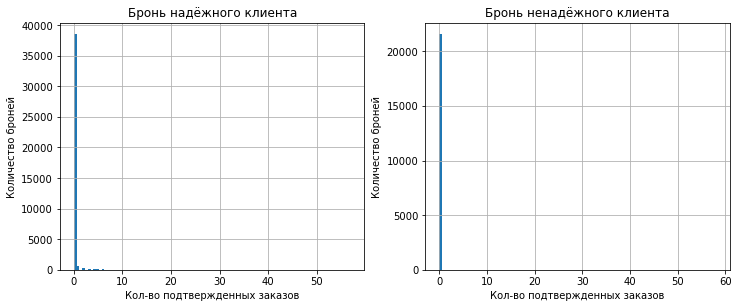

In [55]:
ax = plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
df_train[df_train['is_canceled'] == 0]['previous_bookings_not_canceled'].hist(bins=100)
plt.xlabel('Кол-во подтвержденных заказов')
plt.ylabel('Количество броней')
plt.title('Бронь надёжного клиента')
plt.subplot(2, 2, 2)
df_train[df_train['is_canceled'] == 1]['previous_bookings_not_canceled'].hist(bins=100)
plt.xlabel('Кол-во подтвержденных заказов')
plt.ylabel('Количество броней')
plt.title('Бронь ненадёжного клиента')
plt.show()

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center">Мини-вывод<a class="tocSkip"> </h2>
Очень много данных, где человек имеет 0 подтвержденных броней и 0 отказов, в итоге сложно что-то говорить. Если у человека есть 1 отмененный заказ, то больше шансов, что он отменит, чем если бы у него не было отмененного ранее заказа. В случае подтвержденного заказа не влияет есть подтвержденные заказы или нет, т.к. у обоих групп 0 является основным значением.

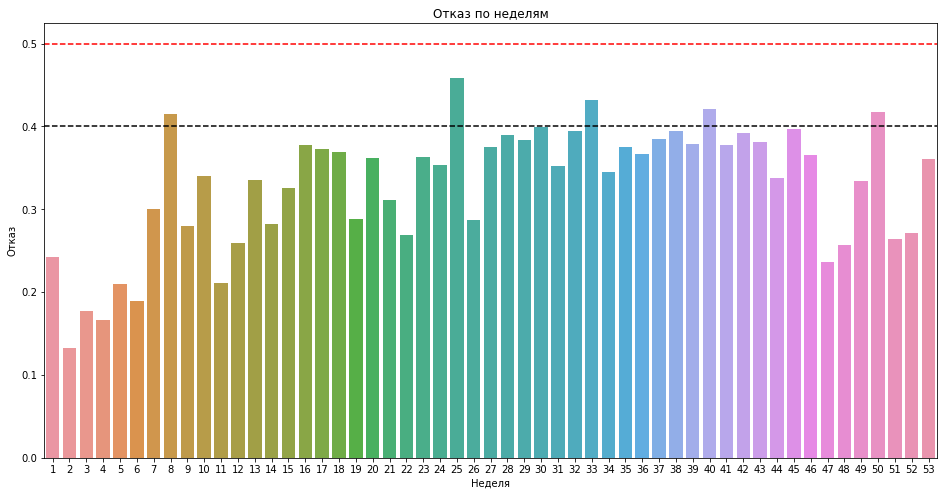

In [56]:
adwn_figure = pd.DataFrame(dict(df_train.groupby('arrival_date_week_number')['is_canceled'].mean()), index = [0])
plt.figure(figsize=(16, 8))
ax = sns.barplot(data=adwn_figure);
ax.axhline(0.4, color="black", linestyle="--")
ax.axhline(0.5, color="red", linestyle="--")
plt.xlabel('Неделя');
plt.ylabel('Отказ');
plt.title('Отказ по неделям');
plt.show()

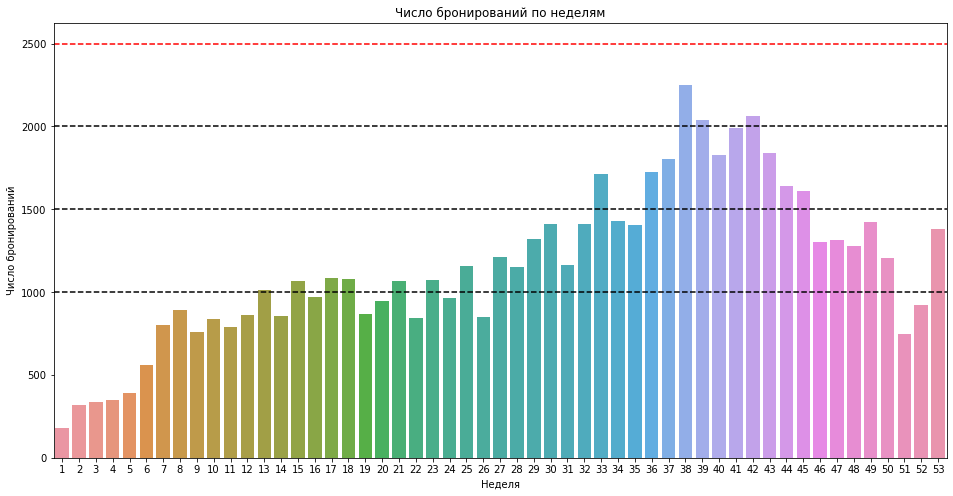

In [57]:
adwn_count = pd.DataFrame(dict(df_train.groupby('arrival_date_week_number')['is_canceled'].count()), index = [0])
plt.figure(figsize=(16, 8))
ax = sns.barplot(data=adwn_count);
ax.axhline(1500, color="black", linestyle="--")
ax.axhline(2500, color="red", linestyle="--")
ax.axhline(2000, color="black", linestyle="--")
ax.axhline(1000, color="black", linestyle="--")
plt.xlabel('Неделя');
plt.ylabel('Число бронирований');
plt.title('Число бронирований по неделям');
plt.show()

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center">Мини-вывод<a class="tocSkip"> </h2>
Из графиков могу сказать, что наплыв бронирований был ближе к концу года, а также могу сказать, что в 25 неделю было больше всего отказов. На счёт типа заказчика - у нас недостаточно данных для каких-либо выводов. В типе заказчика Transient шанс того, что заказ будет отменен 37 процентов.

In [58]:
df_train.groupby('customer_type')['is_canceled'].mean()

customer_type
Contract           0.374858
Group              0.068100
Transient          0.369917
Transient-Party    0.298617
Name: is_canceled, dtype: float64

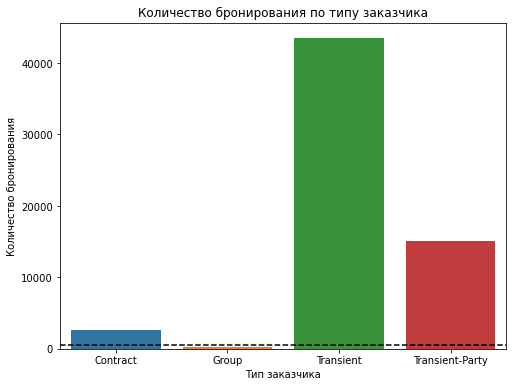

In [59]:
customer_type_count = pd.DataFrame(dict(df_train.groupby('customer_type')['is_canceled'].count()), index = [0])
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=customer_type_count);
plt.xlabel('Тип заказчика');
plt.ylabel('Количество бронирования');
plt.title('Количество бронирования по типу заказчика');
ax.axhline(500, color="black", linestyle="--")
plt.show()

Мало данных для определенного вывода


In [60]:
# пишу функцию для добавления числового столбца с месяцами
def replace_month(df):
    number = 0
    if df.loc['arrival_date_month'] == 'January':
        number = 1
    if df.loc['arrival_date_month'] == 'February':
        number = 2
    if df.loc['arrival_date_month'] == 'March':
        number = 3
    if df.loc['arrival_date_month'] == 'April':
        number = 4
    if df.loc['arrival_date_month'] == 'May':
        number = 5
    if df.loc['arrival_date_month'] == 'June':
        number = 6
    if df.loc['arrival_date_month'] == 'July':
        number = 7
    if df.loc['arrival_date_month'] == 'August':
        number = 8
    if df.loc['arrival_date_month'] == 'September':
        number = 9
    if df.loc['arrival_date_month'] == 'October':
        number = 10
    if df.loc['arrival_date_month'] == 'November':
        number = 11
    if df.loc['arrival_date_month'] == 'December':
        number = 12
    return number

In [61]:
# создаю индексы стран, которые встречались очень много раз
country_index_top = df_train['country'].value_counts().head(16).index

In [62]:
# пишу функцию, которая заменит страны, которые встретились очень мало раз, на единую группу
def replace_country(df):
    if df['country'] not in country_index_top:
        return 'OTHER'
    else:
        return df['country']
    
df_train['country'] = df_train.apply(replace_country, axis=1)
df_test['country'] = df_test.apply(replace_country, axis=1)

In [63]:
df_train['arrival_date_month_new'] = df_train.apply(replace_month, axis=1)
df_test['arrival_date_month_new'] = df_test.apply(replace_month, axis=1)

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center">Промежуточный вывод<a class="tocSkip"> </h2>
Был проведен исследовательский анализ данных, с помощью которого было выявлено, что чаще всего отказываются от брони в Августе, Сентябре, Июле, Июне, Октябре, Апреле; меньше отказов в первые 100 дней брони; чем больше количество дней между датой бронирования и датой прибытия, тем больше шанс, что клиент откажется, чем больше количество изменений параметров заказа, количество специальных отметок и мест для автомобилей, тем меньше шанс того, что клиент откажется; больше всего отказов происходит в середине месяца, а именно: в 17 день, а больше всего броней происходит на 6 день, 17 и 26; если у человека есть 1 отмененный заказ, то больше шансов, что он отменит, чем если бы у него не было отмененного ранее заказа; наплыв бронирований был ближе к концу года, а также могу сказать, что в 25 неделю было больше всего отказов; в типе заказчика Transient шанс того, что заказ будет отменен 37 процентов. Для удобства работы с данными были написаны функции, также было построено довольно таки много графиков, с помощью которых была облегчено понимание некоторых сравнений и т.д. Были удалены выбросы и найдены столбцы, которые не будут нужны для обучения модели.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

In [64]:
winter = ['December', 'January', 'February']
spring = ['March', 'April', 'May']
autumn = ['September', 'October', 'November']
summer = ['June', 'July', 'August']
# функция для добавления столбца с сезоном
def column_season(df):
    if df['arrival_date_month'] in winter:
        return 'winter'
    if df['arrival_date_month'] in summer:
        return 'summer'
    if df['arrival_date_month'] in autumn:
        return 'autumn'
    if df['arrival_date_month'] in spring:
        return 'spring'
# функция для добавления столбца со след. месяцем
def next_month(df):
    if df['arrival_date_month_new'] == 12:
        return 1
    else:
        return df['arrival_date_month_new'] + 1
# функция для добавления столбца с процентом повышения цен в сезон   
def season_percent(df):
    if df['season'] == 'winter':
        return 0
    if df['season'] == 'spring' or df['season'] == 'autumn':
        return 0.2
    if df['season'] == 'summer':
        return 0.4

winter_number = [12, 1, 2]
spring_number = [3, 4, 5]
autumn_number = [9, 10, 11]
summer_number = [6, 7 ,8]    
    
# функция для добавления столбца с сезоном для след. месяца
def season_percent_next_month(df):
    if df['next_month'] in winter_number:
        return 0
    if df['next_month'] in spring_number or df['next_month'] in autumn_number:
        return 0.2
    if df['next_month'] in summer_number:
        return 0.4
    
month_31 = [1, 3, 5, 7, 8, 10, 12]
month_30 = [4, 6, 9, 11]
# функция для добавления столбца со след. месяцем  
def next_month_day(df):
    count = 0
    season = df['season']
    month = df['arrival_date_month_new']
    nights = df['total_nights']
    day = df['arrival_date_day_of_month']
    number = day + nights
    year = df['arrival_date_year']
    
    if year == 2015:
        if month == 2 and number > 28:
                return number - 29
        if month == 2 and number <= 28:
            return 0
    if year == 2016:
        if month == 2 and number > 29:
                return number - 30
        if month == 2 and number <= 29:
            return 0
    if year == 2017:
        if month == 2 and number > 28:
                return number - 29
        if month == 2 and number <= 28:
            return 0
    if number > 31 and month in month_31:
            return number - 32
    if number <= 31 and month in month_31:
            return 0
    if number > 30 and month in month_30:
            return number - 31
    if number <= 30 and month in month_30:
            return 0

In [65]:
# константы
PRICE_A = 1000
PRICE_B = 800
PRICE_C = 600
PRICE_D = 550
PRICE_E = 500
PRICE_F = 450
PRICE_G = 350
PRICE_CLEANING_A = 400
PRICE_CLEANING_B = 350
PRICE_CLEANING_C = 350
PRICE_CLEANING_D = 150
PRICE_CLEANING_E = 150
PRICE_CLEANING_F = 150
PRICE_CLEANING_G = 150

In [66]:
def season_profit(df):
    profit = 0
    nights_all = df['total_nights']
    room = df['reserved_room_type']
    percent = df['percent']
    next_nights = df['next_month_day']
    next_month = df['next_month']
    percent_next = df['percent_next_month']
    nights_now = abs(nights_all - next_nights)
    
    if room == 'A':
        price = PRICE_A
        price_cleaning = PRICE_CLEANING_A
    elif room == 'B':
        price = PRICE_B
        price_cleaning = PRICE_CLEANING_B
    elif room == 'C':
        price = PRICE_C
        price_cleaning = PRICE_CLEANING_C
    elif room == 'D':
        price = PRICE_D
        price_cleaning = PRICE_CLEANING_D
    elif room == 'E':
        price = PRICE_E
        price_cleaning = PRICE_CLEANING_E
    elif room == 'F':
        price = PRICE_F
        price_cleaning = PRICE_CLEANING_F
    else:
        price = PRICE_G
        price_cleaning = PRICE_CLEANING_G
        
    
    if nights_all == 1:
        if df['is_canceled'] == 0:
            profit += price + price * percent - price_cleaning
    
    if nights_all > 1:
        if df['is_canceled'] == 0:
            profit += ((price + price * percent) * nights_now 
                           + (price + price * percent_next) * next_nights 
                           - price_cleaning * np.ceil((nights_all / 2)))
            
                
    if df['is_canceled'] == 1:
        profit -= price_cleaning
        
    return profit

In [67]:
df_test['season'] = df_test.apply(column_season, axis=1)
df_train['season'] = df_train.apply(column_season, axis=1)

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center">Мини-вывод<a class="tocSkip"> </h2>
Я сделал очень много новых столбцов, с помощью которых буду вычислять прибыль. Некоторые столбцы для того, чтобы посчитать прибыль 1 заказа за 2 месяца, есть такие заказы, когда человек забронировал номер на конец месяца и на несколько дней, выходит, что дни переходят на след. месяц и цена, возможно, будет выше. Столбцы сделаны именно для этого  

In [68]:
df_train_profit = df_train[['season', 
                  'arrival_date_month_new', 
                  'arrival_date_day_of_month', 
                  'total_nights', 
                  'reserved_room_type', 
                  'is_canceled', 
                  'arrival_date_year']]

In [69]:
# функция для создания новых столбцов
def processing_data(df):
    df['next_month_day'] = df.apply(next_month_day, axis=1)
    df['next_month'] = df.apply(next_month, axis=1)
    df['percent'] = df.apply(season_percent, axis=1)
    df['percent_next_month'] = df.apply(season_percent_next_month, axis=1)
    
    
    return df

In [70]:
df_train_profit.query('season == "summer" & arrival_date_year == 2016')

,season,arrival_date_month_new,arrival_date_day_of_month,total_nights,reserved_room_type,is_canceled,arrival_date_year
4152,summer,6,1,3,A,1,2016
4153,summer,6,1,3,A,1,2016
4154,summer,6,1,3,A,1,2016
4155,summer,6,1,3,A,1,2016
4156,summer,6,1,3,A,1,2016
...,...,...,...,...,...,...,...
58408,summer,8,29,7,D,0,2016
58409,summer,8,31,5,A,0,2016
58448,summer,8,30,7,A,0,2016
58462,summer,8,30,8,A,0,2016


In [71]:
# считаю прибыль по месяцам
df_summer = df_train_profit.query('season == "summer" & arrival_date_year == 2016')
df_winter = df_train_profit.query('season == "winter" & arrival_date_year == 2016')
df_spring = df_train_profit.query('season == "spring" & arrival_date_year == 2016')
df_autumn = df_train_profit.query('season == "autumn" & arrival_date_year == 2016')

df_summer = processing_data(df_summer)
df_winter = processing_data(df_winter)
df_spring = processing_data(df_spring)
df_autumn = processing_data(df_autumn)

PROFIT_SUMMER = df_summer.apply(season_profit, axis=1).sum()
PROFIT_WINTER = df_winter.apply(season_profit, axis=1).sum()
PROFIT_SPRING = df_spring.apply(season_profit, axis=1).sum()
PROFIT_AUTUMN = df_autumn.apply(season_profit, axis=1).sum()

PROFIT_NOT_DEPOSIT = PROFIT_SUMMER + PROFIT_WINTER + PROFIT_SPRING + PROFIT_AUTUMN

In [72]:
PROFIT_NOT_DEPOSIT

69891570.0

In [73]:
print('Количество бронирований за лето -', df_summer.shape[0])
print('Количество бронирований за зиму -', df_winter.shape[0])
print('Количество бронирований за весну -', df_spring.shape[0])
print('Количество бронирований за осень -', df_autumn.shape[0])

Количество бронирований за лето - 11128
Количество бронирований за зиму - 7925
Количество бронирований за весну - 12539
Количество бронирований за осень - 12563


In [74]:
# создаю датафрейм с прибылью по каждому сезону
profit_season = pd.DataFrame({'winter': PROFIT_WINTER,
                              'summer': PROFIT_SUMMER, 
                              'spring':PROFIT_SPRING, 
                              'autumn': PROFIT_AUTUMN},
                              index=[0])

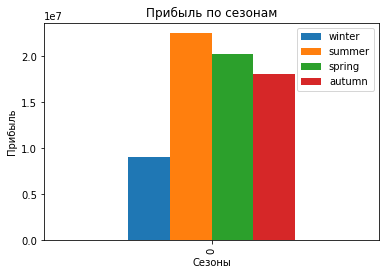

In [75]:
# создаю диаграмму 
profit_season.plot(kind='bar');
plt.xlabel('Сезоны');
plt.ylabel('Прибыль');
plt.title('Прибыль по сезонам');

In [76]:
df_train[df_train['arrival_date_year'] == 2016]['arrival_date_month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype=object)

In [77]:
df_not_deposit_test = df_test[['season', 
                  'arrival_date_month_new', 
                  'arrival_date_day_of_month', 
                  'total_nights', 
                  'reserved_room_type', 
                  'is_canceled', 
                  'arrival_date_year']]

In [78]:
df_not_deposit_test = processing_data(df_not_deposit_test)
PROFIT_NOT_DEPOSIT_TEST = df_not_deposit_test.apply(season_profit, axis=1).sum()

In [79]:
PROFIT_NOT_DEPOSIT_TEST

48812600.0

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center">Мини-вывод<a class="tocSkip"> </h2>
За 1 год прибыль составила 69.891.570, а за 1 год(тестовой выборки) 48.812.600, самым прибыльным сезоном вышло лето.

### Шаг 4. Разработка модели ML

In [80]:
df_test['merge'] = 1

In [81]:
data = df_train.merge(df_test, how='outer')
data['merge'] = data['merge'].fillna(0)
data.drop(columns=['days_in_waiting_list', 
                       'arrival_date_year', 
                       'children', 
                       'babies', 
                       'is_repeated_guest', 
                       'previous_cancellations', 
                       'previous_bookings_not_canceled', 
                       'required_car_parking_spaces'], inplace=True)

df_train.drop(columns=['days_in_waiting_list', 
                       'arrival_date_year', 
                       'children', 
                       'babies', 
                       'is_repeated_guest', 
                       'previous_cancellations', 
                       'previous_bookings_not_canceled', 
                       'required_car_parking_spaces'], inplace=True)

In [82]:
# пишу функцию, которая произведет стандартизацию и onehotencoder
numeric = ['lead_time',  
           'arrival_date_month_new',
           'arrival_date_week_number',
           'arrival_date_day_of_month',
           'stays_in_weekend_nights',
           'stays_in_week_nights',
           'adults',
           'booking_changes',
           'total_of_special_requests',
           'total_nights']

scaler = StandardScaler()
standard = scaler.fit(df_train[numeric])


data[numeric] = standard.transform(data[numeric])
data = pd.get_dummies(data, drop_first=True, columns=['meal', 
                                                  'country',
                                                  'distribution_channel', 
                                                  'reserved_room_type', 
                                                  'customer_type'])

In [83]:
df_test_new = data[data['merge'] == 1]
df_train_new = data[data['merge'] == 0]
df_test_new.drop(columns = ['merge'], inplace=True)
df_train_new.drop(columns = ['merge'], inplace=True)

In [84]:
features_train = df_train_new.drop(columns=['is_canceled', 'season', 'arrival_date_month'], axis=0)
features_test = df_test_new.drop(columns=['is_canceled', 'season', 'arrival_date_month'], axis=0)
target_train = df_train_new['is_canceled']
target_test = df_test_new['is_canceled']

In [85]:
# функция для того, чтобы избавиться от дисбаланса
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [86]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 2)

In [87]:
# было
target_train.value_counts()

0    39907
1    21606
Name: is_canceled, dtype: int64

In [88]:
# стало
target_upsampled.value_counts()

1    43212
0    39907
Name: is_canceled, dtype: int64

In [89]:
# произвожу RandomizedSearchCV с кросс-валидацией и ищу лучшие параметры
dtc = DecisionTreeClassifier()
param_tree = {
    'max_depth': list(range(1, 100)),
    'criterion': ['gini', 'entropy'],
    'min_samples_split': list(range(2, 6)),
    'max_features': ["auto", "sqrt", "log2"]
}

rsc = RandomizedSearchCV(
    dtc, 
    param_tree, 
    scoring='f1',
    cv=5,
    random_state = 12345,
    n_iter=150
)

rsc.fit(features_train, target_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=150,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': [2, 3, 4, 5]},
                   random_state=12345, scoring='f1')

In [90]:
print(rsc.best_params_)
print(rsc.best_score_)

{'min_samples_split': 4, 'max_features': 'log2', 'max_depth': 11, 'criterion': 'gini'}
0.5297011618932187


In [91]:
# обучаю дерево
tree_model = DecisionTreeClassifier(max_depth=11, max_features='log2', min_samples_split=4, criterion='gini', random_state=12345)
tree_model.fit(features_upsampled, target_upsampled)
predictions = tree_model.predict(features_test)
dtc_score = f1_score(target_test, predictions)
print(dtc_score)

0.6369958275382476


In [92]:
# произвожу RandomizedSearchCV с кросс-валидацией и ищу лучшие параметры
forest = RandomForestClassifier()
param_forest = {
    'n_estimators': list(range(1, 300)),
    'max_depth': list(range(1, 100)),
    'criterion': ['gini', 'entropy'],
    'max_features': ["auto", "sqrt", "log2"]
}

forest_rsc = RandomizedSearchCV(
    forest, 
    param_forest, 
    scoring='f1', 
    cv=5,
    random_state = 12345,
    n_iter=75
)

forest_rsc.fit(features_train, target_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=75,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
     

In [93]:
print(forest_rsc.best_params_)
print(forest_rsc.best_score_)

{'n_estimators': 122, 'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'entropy'}
0.5166616478777366


In [94]:
# обучаю лес
model = RandomForestClassifier(n_estimators=122, max_depth=6, max_features='sqrt', criterion='entropy', random_state=12345)
model.fit(features_upsampled, target_upsampled)
predictions = model.predict(features_test)
rfc_score = f1_score(target_test, predictions)
print(rfc_score)

0.6712587676928893


In [95]:
# произвожу кросс-валидацию
log_regress = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=1, random_state=12345)
log_scores = cross_validate(log_regress, features_train, target_train, scoring='f1', cv=5)
print('mean score:', sum(log_scores['test_score']) / len(log_scores['test_score']))

mean score: 0.5813050427807418


In [96]:
# обучаю логистическую регрессию
log_regress.fit(features_upsampled, target_upsampled)
predictions = log_regress.predict(features_test)
log_score = f1_score(target_test, predictions)
print(log_score)

0.6682868525896414


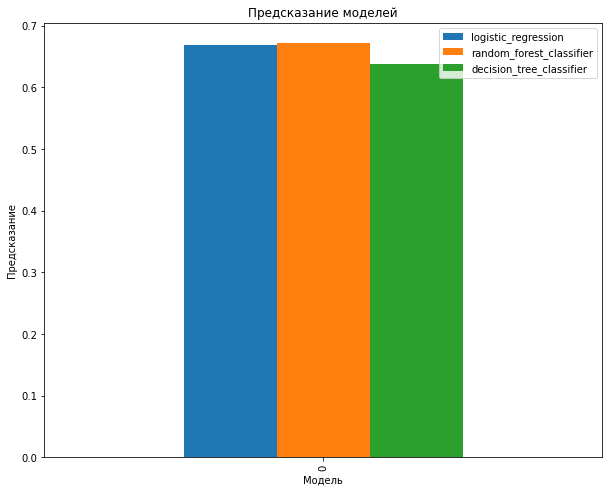

In [97]:
# с помощью графика выявляю лучшую модель
best_model = pd.DataFrame({'logistic_regression': log_score,
                           'random_forest_classifier': rfc_score,
                           'decision_tree_classifier': dtc_score}, index=[0])
best_model.plot(kind='bar', figsize=(10,8));
plt.xlabel('Модель');
plt.ylabel('Предсказание');
plt.title('Предсказание моделей');

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center">Мини-вывод<a class="tocSkip"> </h2>
Из графика видно, что модель RandomForestClassifier предсказывает лучше остальных. Итог - выбираем модель RandomForestClassifier

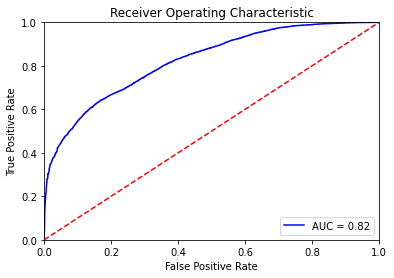

In [98]:
probs = model.predict_proba(features_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(target_test, preds)


roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [99]:
# подготавливаю данные для подсчета прибыли с помощью депозита
df_deposit_test_new = df_test_new.drop(columns=['is_canceled', 'arrival_date_month', 'season'], axis=0)
prediction_deposit = model.predict(df_deposit_test_new)

In [100]:
df_test['is_canceled_new'] = pd.Series(prediction_deposit, index=df_test.index)

In [101]:
df_deposit = df_test[['season', 
                  'arrival_date_month_new', 
                  'arrival_date_day_of_month', 
                  'total_nights', 
                  'reserved_room_type', 
                  'is_canceled_new', 
                      'is_canceled', 
                  'arrival_date_year']]

df_deposit = processing_data(df_deposit)

In [102]:
def profit_deposit(df):
    profit = 0
    nights_all = df['total_nights']
    room = df['reserved_room_type']
    percent = df['percent']
    next_nights = df['next_month_day']
    next_month = df['next_month']
    percent_next = df['percent_next_month']
    nights_now = abs(nights_all - next_nights)
    
    if room == 'A':
        price = PRICE_A
        price_cleaning = PRICE_CLEANING_A
    elif room == 'B':
        price = PRICE_B
        price_cleaning = PRICE_CLEANING_B
    elif room == 'C':
        price = PRICE_C
        price_cleaning = PRICE_CLEANING_C
    elif room == 'D':
        price = PRICE_D
        price_cleaning = PRICE_CLEANING_D
    elif room == 'E':
        price = PRICE_E
        price_cleaning = PRICE_CLEANING_E
    elif room == 'F':
        price = PRICE_F
        price_cleaning = PRICE_CLEANING_F
    else:
        price = PRICE_G
        price_cleaning = PRICE_CLEANING_G
        
    if (df['is_canceled_new'] == 0 and df['is_canceled'] == 0) or (df['is_canceled_new'] == 1 and df['is_canceled'] == 0):
    
        if nights_all == 1:
            profit += price + price * percent - price_cleaning
    
        if nights_all > 1:
            profit += ((price + price * percent) * nights_now 
                           + (price + price * percent_next) * next_nights 
                           - price_cleaning * np.ceil((nights_all / 2)))
    
    if df['is_canceled_new'] == 1 and df['is_canceled_new'] == 1:
        profit += (price + price * percent + price_cleaning) * 0.8 - price_cleaning
                    
    if df['is_canceled_new'] == 1 and df['is_canceled_new'] == 0:      
        profit -= price_cleaning         
        
    return profit

In [103]:
PROFIT_DEPOSIT = df_deposit.apply(profit_deposit, axis=1).sum()

In [104]:
PROFIT_DEPOSIT

62300818.0

In [105]:
pd.DataFrame({'not_deposit': PROFIT_NOT_DEPOSIT_TEST, 
              'deposit': PROFIT_DEPOSIT}, index=[0])

,not_deposit,deposit
0,48812600.0,62300818.0


<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center">Мини-вывод<a class="tocSkip"> </h2>
Прибыль без депозитов составляла 49 миллион, с помощью модели увеличиваем прибыль на 13 миллионов. Неплохой результат, модель окупается. 

### Шаг 5. Опишите портрет «ненадёжного» клиента

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center">Мини-вывод<a class="tocSkip"> </h2>
Чаще всего отказываются от брони в Августе, Сентябре, Июле, Июне, Октябре, Апреле; чем больше количество дней между датой бронирования и датой прибытия, тем больше шанс, что клиент откажется, чем больше количество изменений параметров заказа, количество специальных отметок и мест для автомобилей, тем меньше шанс того, что клиент откажется; больше всего отказов происходит в середине месяца, а именно: в 17 день, а больше всего броней происходит на 6 день, 17 и 26; если у человека есть 1 отмененный заказ, то больше шансов, что он отменит, чем если бы у него не было отмененного ранее заказа; наплыв бронирований был ближе к концу года, а также могу сказать, что в 25 неделю было больше всего отказов; в типе заказчика Transient шанс того, что заказ будет отменен 37 процентов.

### Шаг 6. Напишите общий вывод

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center">Вывод<a class="tocSkip"> </h2>
С помощью данной работы я смог потренироваться, сделать различные исследования, закрепить материал, узнать много нового и обучить RandomForestClassifier, который увеличил прибыль на 13 миллионов. Выбрал я модель RandomForestClassifier.